Import packages.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import dual_sourcing

Set up configurations for the environment.

In [2]:
CONFIG = {'Lr': 5, 'Le': 1, 'cr': 100, 'ce': 105, 'lambda': 10,
          'h': 1, 'b': 19, 'starting_state': [0]*7, 'max_order': 20, 'max_inventory': 1000}

Make an instance of the environment.

In [3]:
env = gym.make('DualSourcing-v0', config=CONFIG)

Print the environment settings.

In [5]:
print(env.state)
print(env.action_space)
print(env.observation_space)

[0 0 0 0 0 0 0]
MultiDiscrete([21 21])
MultiDiscrete([  21   21   21   21   21   21 1000])


Test the step function.

In [6]:
env.seed(0)
env.state = [0] * 7
print(env.step([8, 2]))
print('***')
env.state = [5, 4, 5, 6, 6, 2, 2]
print(env.step([3, 1]))

(array([  0,   0,   0,   0,   8,   2, -10]), 0, 10, {})
***
(array([ 4,  5,  6,  6,  3,  1, -2]), -812, 11, {})


Evaluate an estimate of the value function for a certain policy by doing multiple episodes of simulation.

In [39]:
def evaluate(env, n_episodes, numiters, policy, *args):
    # env: gym environment
    # n_episodes: number of total episodes to run (outer iteration)
    # numiters: number of time steps (inner iteration)
    # policy: policy function
    # *args: arguments in the policy function
    
    av_reward = np.zeros(n_episodes)
    
    for i in range(n_episodes):
        av_r = 0
        env.reset() # reset environment
        for t in range(numiters):
            action = policy(*args)
            state, reward, demand, info = env.step(action)
            if t > 100 and np.abs( av_r / (t+1) - (av_r + reward) / (t+2))  < 1e-4: # convergence is spotted
                break
            av_r = av_r + reward
        av_reward[i] = av_r / (t+1)
#         print(t)
        
    return np.mean(av_reward), np.std(av_reward) # return average reward and std

We need to decide on some policy that will not make the average reward blow up. As a result, we write the following function to plot the average reward vs. time step as a guidance.

In [18]:
def convergence_test(env, numiters, policy, *args):

    cum_reward = np.zeros(numiters)
    av_reward = np.zeros(numiters)
    
    env.reset() # reset environment
    for t in range(numiters-1):
        action = policy(*args)
        state, reward, demand, info = env.step(action)
        cum_reward[t+1] = cum_reward[t] + reward
        av_reward[t+1] = cum_reward[t+1] / (t+1)
        
    plt.plot(range(numiters), av_reward)
    plt.xlabel('time step')
    plt.ylabel('average reward')

(1) Random policy.

In [16]:
def random_policy(env):
    return env.action_space.sample()

Text(0.5, 1.0, 'Random policy')

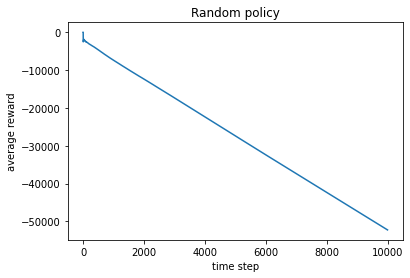

In [20]:
convergence_test(env, 10000, random_policy, env)
plt.title('Random policy')

It is obvious that random policy cannot guarantee convergence.

(2) Constant policy.

In [21]:
def constant_policy(action):
    return action

Text(0.5, 1.0, 'Constant policy')

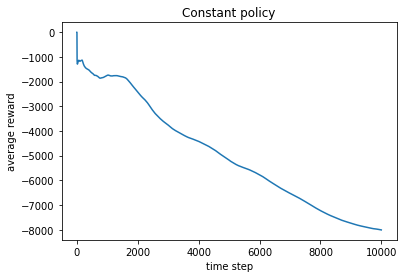

In [24]:
convergence_test(env, 10000, constant_policy, np.array([0,10]))
plt.title('Constant policy')

Constant policy is also not a good candidate.

(3) TBS policy

We shortly walk through the TBS policy here for consistency. A TBS policy $\pi_{r,S}$ is characterized by two parameters $r \in \mathbb{Z}_+$ and $S \in \mathbb{Z}_+$. In each period, the policy always orders $r$ products from $R$ and follows an order-up-to rule from $E$, where we maintain the express inventory position above $S$. That is to say, for all time step $t$, we set 
$$
\begin{array}{rl}
        q_t^r & = r \\
        q_t^e & = \max \left( 0, S-\hat I_t \right),
\end{array}
$$
where $$\hat I_t := I_t + \sum_{i=t-L_e}^{t-1} q_i^e + \sum_{i=t-L_r}^{t-L_r+L_e} q_i^r$$ is the so-called inventory position, which corresponds to the net inventory at the start of period $t$ plus all orders to be received in periods $t,\dots,t+L_e$.

In [25]:
def TBS(env, r, S):
    ip = np.sum(env.state[1:(env.Le+1)]) + np.sum(env.state[env.Lr:])
    return r, max(0, S-ip)

Text(0.5, 1.0, 'TBS')

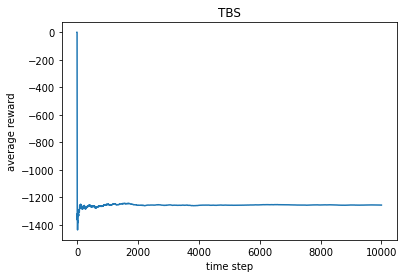

In [27]:
convergence_test(env, 10000, TBS, env, 5, 3)
plt.title('TBS')

Eureka!

As a final step, we use the TBS policy to do the estimation and report the mean as well as the standard deviation.

In [40]:
evaluate(env, 100, 5000, TBS, env, 5, 3)

(-1251.030088094656, 9.175726521778662)

We conclude that for TBS policy with parameter $r=5, S=3$, the estimate for the value function is $-1251$ and the standard deviation is $9.176$.